In [1]:
# Francisco Dominguez Mateos
# 02/09/2020
# Siamese network
# References
#- Dimensionality Reduction by Learning an Invariant Mapping
#    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf

In [2]:
import time
import random as pyrandom
import numpy as onp

import jax.numpy as np
from jax import lax, grad, jit, vmap, value_and_grad
from jax import random
# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, LogSoftmax,parallel)
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.datasets import mnist

In [4]:
# Generate key which is used to generate random numbers
rng = random.PRNGKey(1)

In [5]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1.0
    square_pred = np.square(y_pred)
    #square_pred = K.maximum(y_pred-margin, 0) #y_pred #K.square(y_pred)
    margin_square = np.square(np.maximum(margin - y_pred, 0.0))
    tcost=y_true * square_pred
    fcost=(1.0 - y_true) * margin_square
    return np.mean(tcost + fcost)


In [6]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for m in range(1):
        for d in range(num_classes):
            for i in range(n):
                ridx=pyrandom.randrange(1,n)
                idx=(i+ridx)%n
                z1, z2 = digit_indices[d][i], digit_indices[d][idx]
                pairs += [[x[z1], x[z2]]]
                inc = pyrandom.randrange(1, num_classes)
                dn = (d + inc) % num_classes
                z1, z2 = digit_indices[d][i], digit_indices[dn][i]
                pairs += [[x[z1], x[z2]]]
                labels += [1.0, 0.0]
    return onp.expand_dims(onp.array(pairs).astype("float32"),axis=-1), onp.array(labels).astype("float32")

In [7]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train  = x_train.astype('float32')
x_test   = x_test.astype('float32')
y_train  = y_train.astype("float32")
y_test   = y_test.astype("float32")
x_train /= 255
x_test  /= 255
input_shape = (x_train.shape[1],x_train.shape[1],1)
#input_shape = x_train.shape[1:]

print(input_shape)

(28, 28, 1)


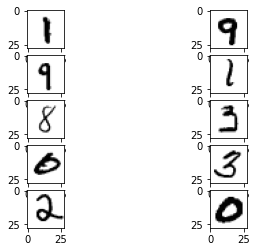

In [8]:
for i in range(5):
    plt.subplot(5,2,i*2+1)
    idx=pyrandom.randrange(0,x_train.shape[0])
    plt.imshow(x_train[idx], cmap="gray_r")
    plt.subplot(5,2,i*2+2)
    idx=pyrandom.randrange(0,x_train.shape[0])
    plt.imshow(x_train[idx], cmap="gray_r")
plt.show()

In [9]:
num_classes = 10
# create training+test positive and negative pairs
digit_indices = [onp.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [onp.where(y_test  == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [10]:
print("tr_pairs=",tr_pairs.shape,"tr_y=",tr_y.shape,tr_y.dtype)
print("te_pairs=",te_pairs.shape,"te_y=",te_y.shape,te_y.dtype)
print(tr_pairs[:, 0].shape)

tr_pairs= (108400, 2, 28, 28, 1) tr_y= (108400,) float32
te_pairs= (17820, 2, 28, 28, 1) te_y= (17820,) float32
(108400, 28, 28, 1)


In [11]:
#Custom layer definitions
def ShareWeights(base_net):
    def init_fun(key,input_shape):
        init=base_net[0]
        nlayers=len(input_shape)
        output_shape,params=init(key,input_shape[0])
        return [output_shape]*nlayers,params
    def apply_fun(params,inputs,**kwargs):
        net=base_net[1]
        return [net(params,input) for input in inputs]
    return init_fun, apply_fun    
def Euclidean():
    def init_fun(key,input_shape):
        assert(len(input_shape)==2)
        output_shape=(input_shape[0][0],)
        return output_shape,()
    def apply_fun(params, inputs, **kwargs):
        assert(len(input_shape)==2)
        epsilon=1e-6
        x, y = inputs
        sum_square = np.sum(np.square(x - y), axis=1)
        return np.sqrt(np.maximum(sum_square, epsilon))
    return init_fun, apply_fun    

In [12]:
embedding_dim=2
# Conv seems to work with NHWC but it works with NCHW too
init_base, base_net = stax.serial(Conv(32, (5, 5), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(32, (5, 5), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(10, (3, 3), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(10, (3, 3), (2, 2), padding="SAME"), Relu,
                                 Flatten,
                                 Dense(embedding_dim))

init_siamese,siamese_net=stax.serial(
    ShareWeights((init_base, base_net)),
    Euclidean()
)

In [13]:
data_shape=(-1,2,28,28,1)
input_shape_base=(data_shape[0],*data_shape[2:])
input_shape=[input_shape_base]*2
print(input_shape)
output_shape,params=init_siamese(rng,input_shape)
print("ouput_shape=",output_shape)

[(-1, 28, 28, 1), (-1, 28, 28, 1)]
ouput_shape= (-1,)


In [14]:
# Make a batched version of the `net` function
#siamese_net = vmap(siamese_net , in_axes=(None, 0), out_axes=0)

In [15]:
input_test=[tr_pairs[:10,0],tr_pairs[:10,1]]
dist=siamese_net(params,input_test)
print(dist.shape,dist)

(10,) [0.56533825 0.8876414  1.1003287  1.6434132  0.49285623 0.24211289
 0.6570706  0.30821866 0.27589    1.0837042 ]


In [16]:
def contrastive_loss(params,inputs,label):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    dist_pred=siamese_net(params,inputs)
    margin_f = 1.0
    margin_t = 0.5
    push_t = dist_pred #pushing toward 0 aka minimizing :-)
    #push_t = np.maximum(dist_pred - margin_t, 0.0 )#pushing toward in  margin_t and then let free
    push_f = np.maximum(margin_f - dist_pred, 0.0 )#pushign toward out margin_f and then let free
    tcost  = label * push_t
    fcost  = (1.0 - label) * push_f
    return np.mean(tcost + fcost)

In [17]:
label_test=np.array([1]*10)
l=contrastive_loss(params,input_test,label_test)
print(l.shape,l)

() 0.7256574


In [18]:
def compute_accuracy(params,inputs,label):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    dist_pred=siamese_net(params,inputs)
    pred = dist_pred.ravel() < 0.5
    return np.mean(label == pred)

In [19]:
label_test=np.array([0]*10)
a=compute_accuracy(params,input_test,label_test)
print(a.shape,a)

() 0.6


In [20]:
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In [21]:
def getBatch(x,y,i,batch_size):
    bx=[x[j][i*batch_size:i*batch_size+batch_size] for j in range(len(x))]
    by=    y[i*batch_size:i*batch_size+batch_size]
    return bx,by

In [22]:
batch_test=getBatch(input_test,label_test,1,3)
print(batch_test[0][0].shape,batch_test[0][1].shape,batch_test[1].shape)

(3, 28, 28, 1) (3, 28, 28, 1) (3,)


In [23]:
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(contrastive_loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [24]:
params,opt_state,value=update(params,batch_test[0],batch_test[1],opt_state)
print(value)

0.26695597


In [25]:
def fit(opt_state,x,t,batch_size=100,epochs=1,validation_data=None):
    num_complete_batches, leftover = divmod(x[0].shape[0], batch_size)
    num_batches = num_complete_batches + bool(leftover)
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    test_acc  = compute_accuracy(params, validation_data[0],validation_data[1])
    train_acc = compute_accuracy(params, *getBatch(x,t,0,batch_size))
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Loop over the training epochs
    for epoch in range(epochs):
        start_time = time.time()
        for ib in range(num_batches):
            bx,by=getBatch(x,t,ib,batch_size)
            params, opt_state, loss = update(params, bx, by, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        test_acc  = compute_accuracy(params, validation_data[0],validation_data[1])
        test_loss = contrastive_loss(params, validation_data[0],validation_data[1])
        train_acc = compute_accuracy(params, *getBatch(x,t,0,batch_size))
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | T: {:0.2f} | Loss {:0.4f} | Train A: {:0.4f} | Loss {:0.4f} | Test A: {:0.4f}".format(epoch+1, epoch_time,
                                                                    loss,train_acc, test_loss, test_acc))
    return opt_state,train_loss, log_acc_train, log_acc_test

In [26]:
validation_data=((te_pairs[:,0],te_pairs[:,1]), te_y)
data=[tr_pairs[:,0],tr_pairs[:,1]]
labels=tr_y

In [37]:
batch_size=20000
epochs=1000
opt_state,train_loss,log_acc_train,log_acc_test=fit(opt_state,data,labels,batch_size,epochs,validation_data)

Epoch 1 | T: 0.33 | Loss 0.1421 | Train A: 0.9532 | Loss 0.1650 | Test A: 0.9119
Epoch 2 | T: 0.80 | Loss 0.1419 | Train A: 0.9535 | Loss 0.1648 | Test A: 0.9116
Epoch 3 | T: 0.82 | Loss 0.1415 | Train A: 0.9537 | Loss 0.1644 | Test A: 0.9122
Epoch 4 | T: 0.32 | Loss 0.1414 | Train A: 0.9537 | Loss 0.1642 | Test A: 0.9122
Epoch 5 | T: 0.34 | Loss 0.1409 | Train A: 0.9542 | Loss 0.1638 | Test A: 0.9125
Epoch 6 | T: 0.32 | Loss 0.1407 | Train A: 0.9544 | Loss 0.1636 | Test A: 0.9124
Epoch 7 | T: 0.33 | Loss 0.1403 | Train A: 0.9548 | Loss 0.1633 | Test A: 0.9122
Epoch 8 | T: 0.33 | Loss 0.1401 | Train A: 0.9545 | Loss 0.1631 | Test A: 0.9127
Epoch 9 | T: 0.33 | Loss 0.1397 | Train A: 0.9556 | Loss 0.1628 | Test A: 0.9126
Epoch 10 | T: 0.33 | Loss 0.1395 | Train A: 0.9548 | Loss 0.1626 | Test A: 0.9132
Epoch 11 | T: 0.32 | Loss 0.1391 | Train A: 0.9559 | Loss 0.1623 | Test A: 0.9135
Epoch 12 | T: 0.34 | Loss 0.1389 | Train A: 0.9554 | Loss 0.1621 | Test A: 0.9134
Epoch 13 | T: 0.32 | Loss

Epoch 102 | T: 0.33 | Loss 0.1195 | Train A: 0.9682 | Loss 0.1461 | Test A: 0.9233
Epoch 103 | T: 0.32 | Loss 0.1196 | Train A: 0.9683 | Loss 0.1461 | Test A: 0.9217
Epoch 104 | T: 0.32 | Loss 0.1197 | Train A: 0.9686 | Loss 0.1459 | Test A: 0.9234
Epoch 105 | T: 0.32 | Loss 0.1199 | Train A: 0.9684 | Loss 0.1458 | Test A: 0.9217
Epoch 106 | T: 0.33 | Loss 0.1199 | Train A: 0.9693 | Loss 0.1455 | Test A: 0.9238
Epoch 107 | T: 0.33 | Loss 0.1201 | Train A: 0.9686 | Loss 0.1455 | Test A: 0.9221
Epoch 108 | T: 0.33 | Loss 0.1199 | Train A: 0.9694 | Loss 0.1452 | Test A: 0.9238
Epoch 109 | T: 0.32 | Loss 0.1201 | Train A: 0.9686 | Loss 0.1452 | Test A: 0.9222
Epoch 110 | T: 0.33 | Loss 0.1198 | Train A: 0.9698 | Loss 0.1450 | Test A: 0.9238
Epoch 111 | T: 0.33 | Loss 0.1199 | Train A: 0.9687 | Loss 0.1451 | Test A: 0.9221
Epoch 112 | T: 0.33 | Loss 0.1195 | Train A: 0.9699 | Loss 0.1447 | Test A: 0.9238
Epoch 113 | T: 0.33 | Loss 0.1194 | Train A: 0.9690 | Loss 0.1447 | Test A: 0.9223
Epoc

Epoch 201 | T: 0.33 | Loss 0.1064 | Train A: 0.9736 | Loss 0.1364 | Test A: 0.9262
Epoch 202 | T: 0.33 | Loss 0.1058 | Train A: 0.9736 | Loss 0.1363 | Test A: 0.9274
Epoch 203 | T: 0.34 | Loss 0.1058 | Train A: 0.9737 | Loss 0.1363 | Test A: 0.9260
Epoch 204 | T: 0.33 | Loss 0.1051 | Train A: 0.9738 | Loss 0.1362 | Test A: 0.9276
Epoch 205 | T: 0.34 | Loss 0.1051 | Train A: 0.9737 | Loss 0.1363 | Test A: 0.9262
Epoch 206 | T: 0.33 | Loss 0.1043 | Train A: 0.9739 | Loss 0.1361 | Test A: 0.9273
Epoch 207 | T: 0.33 | Loss 0.1044 | Train A: 0.9739 | Loss 0.1362 | Test A: 0.9264
Epoch 208 | T: 0.33 | Loss 0.1037 | Train A: 0.9738 | Loss 0.1360 | Test A: 0.9273
Epoch 209 | T: 0.33 | Loss 0.1037 | Train A: 0.9741 | Loss 0.1361 | Test A: 0.9263
Epoch 210 | T: 0.33 | Loss 0.1031 | Train A: 0.9741 | Loss 0.1358 | Test A: 0.9273
Epoch 211 | T: 0.33 | Loss 0.1030 | Train A: 0.9742 | Loss 0.1359 | Test A: 0.9265
Epoch 212 | T: 0.33 | Loss 0.1026 | Train A: 0.9742 | Loss 0.1356 | Test A: 0.9274
Epoc

Epoch 300 | T: 0.33 | Loss 0.0944 | Train A: 0.9769 | Loss 0.1304 | Test A: 0.9279
Epoch 301 | T: 0.33 | Loss 0.0937 | Train A: 0.9781 | Loss 0.1305 | Test A: 0.9295
Epoch 302 | T: 0.33 | Loss 0.0940 | Train A: 0.9772 | Loss 0.1306 | Test A: 0.9282
Epoch 303 | T: 0.33 | Loss 0.0932 | Train A: 0.9781 | Loss 0.1308 | Test A: 0.9292
Epoch 304 | T: 0.33 | Loss 0.0943 | Train A: 0.9771 | Loss 0.1308 | Test A: 0.9280
Epoch 305 | T: 0.32 | Loss 0.0932 | Train A: 0.9778 | Loss 0.1305 | Test A: 0.9292
Epoch 306 | T: 0.33 | Loss 0.0945 | Train A: 0.9769 | Loss 0.1306 | Test A: 0.9273
Epoch 307 | T: 0.33 | Loss 0.0928 | Train A: 0.9781 | Loss 0.1302 | Test A: 0.9299
Epoch 308 | T: 0.33 | Loss 0.0943 | Train A: 0.9769 | Loss 0.1308 | Test A: 0.9274
Epoch 309 | T: 0.33 | Loss 0.0921 | Train A: 0.9780 | Loss 0.1303 | Test A: 0.9296
Epoch 310 | T: 0.33 | Loss 0.0937 | Train A: 0.9768 | Loss 0.1309 | Test A: 0.9278
Epoch 311 | T: 0.33 | Loss 0.0912 | Train A: 0.9780 | Loss 0.1301 | Test A: 0.9295
Epoc

Epoch 399 | T: 0.33 | Loss 0.0881 | Train A: 0.9798 | Loss 0.1262 | Test A: 0.9303
Epoch 400 | T: 0.33 | Loss 0.0863 | Train A: 0.9798 | Loss 0.1258 | Test A: 0.9304
Epoch 401 | T: 0.33 | Loss 0.0879 | Train A: 0.9798 | Loss 0.1260 | Test A: 0.9303
Epoch 402 | T: 0.33 | Loss 0.0861 | Train A: 0.9796 | Loss 0.1258 | Test A: 0.9307
Epoch 403 | T: 0.33 | Loss 0.0880 | Train A: 0.9800 | Loss 0.1259 | Test A: 0.9301
Epoch 404 | T: 0.33 | Loss 0.0860 | Train A: 0.9798 | Loss 0.1258 | Test A: 0.9306
Epoch 405 | T: 0.33 | Loss 0.0877 | Train A: 0.9801 | Loss 0.1259 | Test A: 0.9298
Epoch 406 | T: 0.33 | Loss 0.0855 | Train A: 0.9797 | Loss 0.1258 | Test A: 0.9305
Epoch 407 | T: 0.33 | Loss 0.0873 | Train A: 0.9801 | Loss 0.1259 | Test A: 0.9296
Epoch 408 | T: 0.33 | Loss 0.0851 | Train A: 0.9800 | Loss 0.1258 | Test A: 0.9304
Epoch 409 | T: 0.33 | Loss 0.0869 | Train A: 0.9801 | Loss 0.1259 | Test A: 0.9300
Epoch 410 | T: 0.33 | Loss 0.0846 | Train A: 0.9800 | Loss 0.1257 | Test A: 0.9303
Epoc

Epoch 498 | T: 0.33 | Loss 0.0795 | Train A: 0.9818 | Loss 0.1225 | Test A: 0.9319
Epoch 499 | T: 0.33 | Loss 0.0809 | Train A: 0.9816 | Loss 0.1227 | Test A: 0.9327
Epoch 500 | T: 0.33 | Loss 0.0803 | Train A: 0.9817 | Loss 0.1227 | Test A: 0.9311
Epoch 501 | T: 0.33 | Loss 0.0807 | Train A: 0.9817 | Loss 0.1228 | Test A: 0.9329
Epoch 502 | T: 0.33 | Loss 0.0796 | Train A: 0.9821 | Loss 0.1228 | Test A: 0.9312
Epoch 503 | T: 0.33 | Loss 0.0795 | Train A: 0.9819 | Loss 0.1227 | Test A: 0.9326
Epoch 504 | T: 0.34 | Loss 0.0785 | Train A: 0.9824 | Loss 0.1228 | Test A: 0.9314
Epoch 505 | T: 0.32 | Loss 0.0786 | Train A: 0.9820 | Loss 0.1227 | Test A: 0.9328
Epoch 506 | T: 0.35 | Loss 0.0784 | Train A: 0.9826 | Loss 0.1228 | Test A: 0.9317
Epoch 507 | T: 0.33 | Loss 0.0781 | Train A: 0.9820 | Loss 0.1225 | Test A: 0.9328
Epoch 508 | T: 0.33 | Loss 0.0784 | Train A: 0.9826 | Loss 0.1227 | Test A: 0.9321
Epoch 509 | T: 0.33 | Loss 0.0780 | Train A: 0.9821 | Loss 0.1224 | Test A: 0.9328
Epoc

Epoch 597 | T: 0.33 | Loss 0.0746 | Train A: 0.9840 | Loss 0.1201 | Test A: 0.9352
Epoch 598 | T: 0.33 | Loss 0.0724 | Train A: 0.9834 | Loss 0.1207 | Test A: 0.9333
Epoch 599 | T: 0.33 | Loss 0.0738 | Train A: 0.9842 | Loss 0.1204 | Test A: 0.9338
Epoch 600 | T: 0.33 | Loss 0.0722 | Train A: 0.9833 | Loss 0.1207 | Test A: 0.9338
Epoch 601 | T: 0.33 | Loss 0.0753 | Train A: 0.9839 | Loss 0.1209 | Test A: 0.9331
Epoch 602 | T: 0.33 | Loss 0.0722 | Train A: 0.9840 | Loss 0.1200 | Test A: 0.9342
Epoch 603 | T: 0.33 | Loss 0.0743 | Train A: 0.9845 | Loss 0.1196 | Test A: 0.9350
Epoch 604 | T: 0.33 | Loss 0.0719 | Train A: 0.9833 | Loss 0.1205 | Test A: 0.9327
Epoch 605 | T: 0.33 | Loss 0.0730 | Train A: 0.9844 | Loss 0.1198 | Test A: 0.9347
Epoch 606 | T: 0.33 | Loss 0.0717 | Train A: 0.9838 | Loss 0.1202 | Test A: 0.9339
Epoch 607 | T: 0.33 | Loss 0.0720 | Train A: 0.9842 | Loss 0.1204 | Test A: 0.9335
Epoch 608 | T: 0.33 | Loss 0.0717 | Train A: 0.9839 | Loss 0.1202 | Test A: 0.9347
Epoc

Epoch 696 | T: 0.32 | Loss 0.0676 | Train A: 0.9853 | Loss 0.1183 | Test A: 0.9356
Epoch 697 | T: 0.33 | Loss 0.0670 | Train A: 0.9855 | Loss 0.1185 | Test A: 0.9351
Epoch 698 | T: 0.32 | Loss 0.0676 | Train A: 0.9854 | Loss 0.1180 | Test A: 0.9363
Epoch 699 | T: 0.33 | Loss 0.0675 | Train A: 0.9852 | Loss 0.1182 | Test A: 0.9351
Epoch 700 | T: 0.33 | Loss 0.0674 | Train A: 0.9854 | Loss 0.1182 | Test A: 0.9357
Epoch 701 | T: 0.34 | Loss 0.0669 | Train A: 0.9855 | Loss 0.1181 | Test A: 0.9360
Epoch 702 | T: 0.33 | Loss 0.0665 | Train A: 0.9853 | Loss 0.1184 | Test A: 0.9352
Epoch 703 | T: 0.34 | Loss 0.0654 | Train A: 0.9851 | Loss 0.1186 | Test A: 0.9348
Epoch 704 | T: 0.34 | Loss 0.0660 | Train A: 0.9854 | Loss 0.1180 | Test A: 0.9372
Epoch 705 | T: 0.33 | Loss 0.0671 | Train A: 0.9849 | Loss 0.1187 | Test A: 0.9341
Epoch 706 | T: 0.33 | Loss 0.0661 | Train A: 0.9859 | Loss 0.1177 | Test A: 0.9363
Epoch 707 | T: 0.33 | Loss 0.0664 | Train A: 0.9856 | Loss 0.1176 | Test A: 0.9369
Epoc

Epoch 795 | T: 0.34 | Loss 0.0603 | Train A: 0.9865 | Loss 0.1167 | Test A: 0.9378
Epoch 796 | T: 0.33 | Loss 0.0614 | Train A: 0.9864 | Loss 0.1178 | Test A: 0.9351
Epoch 797 | T: 0.33 | Loss 0.0600 | Train A: 0.9867 | Loss 0.1161 | Test A: 0.9378
Epoch 798 | T: 0.33 | Loss 0.0595 | Train A: 0.9869 | Loss 0.1162 | Test A: 0.9371
Epoch 799 | T: 0.34 | Loss 0.0597 | Train A: 0.9865 | Loss 0.1170 | Test A: 0.9364
Epoch 800 | T: 0.34 | Loss 0.0610 | Train A: 0.9867 | Loss 0.1163 | Test A: 0.9385
Epoch 801 | T: 0.33 | Loss 0.0630 | Train A: 0.9864 | Loss 0.1172 | Test A: 0.9360
Epoch 802 | T: 0.33 | Loss 0.0639 | Train A: 0.9870 | Loss 0.1174 | Test A: 0.9372
Epoch 803 | T: 0.32 | Loss 0.0637 | Train A: 0.9864 | Loss 0.1169 | Test A: 0.9385
Epoch 804 | T: 0.34 | Loss 0.0643 | Train A: 0.9865 | Loss 0.1179 | Test A: 0.9355
Epoch 805 | T: 0.33 | Loss 0.0625 | Train A: 0.9861 | Loss 0.1164 | Test A: 0.9379
Epoch 806 | T: 0.33 | Loss 0.0612 | Train A: 0.9872 | Loss 0.1166 | Test A: 0.9369
Epoc

Epoch 894 | T: 0.33 | Loss 0.0560 | Train A: 0.9878 | Loss 0.1160 | Test A: 0.9368
Epoch 895 | T: 0.33 | Loss 0.0570 | Train A: 0.9872 | Loss 0.1154 | Test A: 0.9384
Epoch 896 | T: 0.33 | Loss 0.0549 | Train A: 0.9874 | Loss 0.1168 | Test A: 0.9355
Epoch 897 | T: 0.32 | Loss 0.0558 | Train A: 0.9872 | Loss 0.1151 | Test A: 0.9391
Epoch 898 | T: 0.33 | Loss 0.0552 | Train A: 0.9877 | Loss 0.1164 | Test A: 0.9352
Epoch 899 | T: 0.33 | Loss 0.0565 | Train A: 0.9872 | Loss 0.1152 | Test A: 0.9378
Epoch 900 | T: 0.33 | Loss 0.0572 | Train A: 0.9881 | Loss 0.1162 | Test A: 0.9370
Epoch 901 | T: 0.62 | Loss 0.0582 | Train A: 0.9877 | Loss 0.1160 | Test A: 0.9378
Epoch 902 | T: 0.33 | Loss 0.0576 | Train A: 0.9880 | Loss 0.1155 | Test A: 0.9382
Epoch 903 | T: 0.33 | Loss 0.0581 | Train A: 0.9879 | Loss 0.1157 | Test A: 0.9376
Epoch 904 | T: 0.33 | Loss 0.0574 | Train A: 0.9871 | Loss 0.1151 | Test A: 0.9386
Epoch 905 | T: 0.33 | Loss 0.0578 | Train A: 0.9874 | Loss 0.1163 | Test A: 0.9356
Epoc

Epoch 993 | T: 0.33 | Loss 0.0514 | Train A: 0.9879 | Loss 0.1153 | Test A: 0.9372
Epoch 994 | T: 0.33 | Loss 0.0507 | Train A: 0.9882 | Loss 0.1162 | Test A: 0.9354
Epoch 995 | T: 0.33 | Loss 0.0521 | Train A: 0.9885 | Loss 0.1146 | Test A: 0.9380
Epoch 996 | T: 0.33 | Loss 0.0505 | Train A: 0.9887 | Loss 0.1157 | Test A: 0.9359
Epoch 997 | T: 0.33 | Loss 0.0531 | Train A: 0.9883 | Loss 0.1146 | Test A: 0.9383
Epoch 998 | T: 0.33 | Loss 0.0528 | Train A: 0.9884 | Loss 0.1161 | Test A: 0.9346
Epoch 999 | T: 0.32 | Loss 0.0564 | Train A: 0.9882 | Loss 0.1145 | Test A: 0.9384
Epoch 1000 | T: 0.33 | Loss 0.0551 | Train A: 0.9886 | Loss 0.1158 | Test A: 0.9354


In [40]:
params=get_params(opt_state)
test_acc  = compute_accuracy(params, validation_data[0],validation_data[1])
print(test_acc)

0.9354096


In [35]:
l=contrastive_loss(params,validation_data[0],validation_data[1])
print(l.shape,l)

() 0.16529281


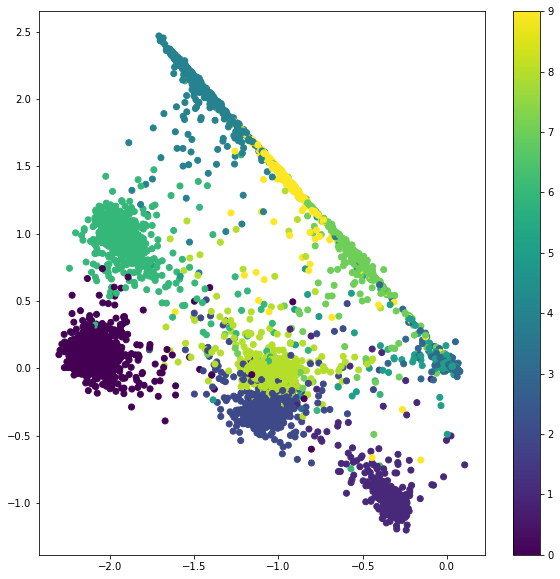

In [41]:
# display a 2D plot of the digit classes in the latent space
base_params=params[0]
ex_test=np.expand_dims(x_test,axis=-1)
x_test_encoded = base_net(base_params,ex_test)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()